In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import pygad



In [2]:
np.random.seed(42)

## Utils

In [3]:
def matrixes_to_solution(A, B, C, num_days):
    """
    Args:
        A: 3D ndarray of shape (num_doctor1, num_faculties, num_days)
        B: 3D ndarray of shape (num_doctor2, num_faculties, num_days)
        C: 3D ndarray of shape (num_nurse, num_faculties, num_days)
    Returns:
        solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
    """
    A = A.reshape(-1, num_days)
    B = B.reshape(-1, num_days)
    C = C.reshape(-1, num_days)
    merged = np.concatenate([A, B, C], axis=0).swapaxes(0, 1)
    return merged.flatten()

def solution_to_matrixes(solution, num_doctor1, num_doctor2, num_nurse, num_faculties, num_days):
    """
    Args:
        solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        num_doctor1: Number of doctors in group 1
        num_doctor2: Number of doctors in group 2
        num_nurse: Number of nurses
        num_faculties: Number of faculties
        num_days: Number of days
    Returns:
        A: 3D ndarray of shape (num_doctor1, num_faculties, num_days)
        B: 3D ndarray of shape (num_doctor2, num_faculties, num_days)
        C: 3D ndarray of shape (num_nurse, num_faculties, num_days)
    """
    solution = solution.reshape(num_days, -1).swapaxes(0, 1)
    endA = num_doctor1 * num_faculties
    endB = endA + num_doctor2 * num_faculties

    A = solution[:endA].reshape(num_doctor1, num_faculties, num_days)
    B = solution[endA:endB].reshape(num_doctor2, num_faculties, num_days)
    C = solution[endB:].reshape(num_nurse, num_faculties, num_days)

    return A, B, C


def sigmoid(x):
    return 1 / (1 + np.exp(-x))



## Dataset Class

In [5]:
def read_to_numpy(file_path):
    """
    Args:
        file_path: Path to the csv file
    Returns:
        year_data: 2D ndarray of shape (num_rows, num_faculties)
                   where year_data[i, j] = years of experience of ith person in jth faculty if exists, 0 otherwise
    """
    data = pd.read_csv(file_path, index_col=False).to_numpy()
    num_faculties = np.max(data[:, 1]) + 1
    year_data = np.zeros((data.shape[0], num_faculties))
    for i in range(data.shape[0]):
        year_data[i, data[i, 1]] = data[i, 0]
    return year_data # 2D ndarray of shape (num_rows, num_faculties)

class Dataset:
    def __init__(self, doctor1_file_path, doctor2_file_path, nurse_file_path, num_doctor1_per_day=1, num_doctor2_per_day=1, num_nurse_per_day=2, num_faculties=4, num_days=61):
        self.doctor1_data = read_to_numpy(doctor1_file_path) # 2D ndarray of shape (num_doctor1, num_faculties)
        self.doctor2_data = read_to_numpy(doctor2_file_path) # 2D ndarray of shape (num_doctor2, num_faculties)
        self.nurse_data = read_to_numpy(nurse_file_path) # 2D ndarray of shape (num_nurse, num_faculties)

        self.num_doctor1 = self.doctor1_data.shape[0] 
        self.num_doctor2 = self.doctor2_data.shape[0]
        self.num_nurse = self.nurse_data.shape[0]

        self.num_doctor1_per_day = num_doctor1_per_day
        self.num_doctor2_per_day = num_doctor2_per_day
        self.num_nurse_per_day = num_nurse_per_day

        self.num_faculties = num_faculties
        self.num_days = num_days
    
    def get_data(self):
        return self.doctor1_data, self.doctor2_data, self.nurse_data


In [6]:
dataset = Dataset('../data/doctor_1.csv', '../data/doctor_2.csv', '../data/nurse.csv')

In [10]:
a = np.nonzero(dataset.doctor1_data)
a = np.transpose(a)
a

array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       [ 3,  1],
       [ 4,  1],
       [ 5,  1],
       [ 6,  1],
       [ 7,  1],
       [ 8,  1],
       [ 9,  2],
       [10,  2],
       [11,  2],
       [12,  2],
       [13,  2],
       [14,  2],
       [15,  3],
       [16,  3],
       [17,  3],
       [18,  3]], dtype=int64)

## Fitness Function

In [6]:
class FitnessFunction:
    def __init__(self, dataset, lambda1=0.1, lambda2=1, lambda3=1, lambda4=1):
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.lambda4 = lambda4
        self.dataset = dataset
        self.doctor1_data, self.doctor2_data, self.nurse_data = dataset.get_data()

    def soft_constraint_1(self, solution):
        """
        Idea: A day should be covered by all faculties
        => Penalize days that are not covered by all faculties (Add 1 for the number of faculties that are not covered for each day)

        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            float
        """
        A, B, C = solution_to_matrixes(solution, self.dataset.num_doctor1, self.dataset.num_doctor2, self.dataset.num_nurse, self.dataset.num_faculties, self.dataset.num_days)
        num_people_per_faculty_per_day = np.sum(np.concatenate([A, B, C], axis=0), axis=0) # shape: (num_faculties, num_days)
        num_faculty_per_day = np.sum(num_people_per_faculty_per_day!=0, axis=0) # shape: (num_days
        num_faculties_not_covered_per_day = self.dataset.num_faculties - num_faculty_per_day # shape: (num_days,)
        fitness = 1 / np.sum(num_faculties_not_covered_per_day) # float

        return sigmoid(fitness) # float in [0, 1]

    def soft_constraint_2(self, solution):
        """
        Idea: A day should not have too low total years of experience
        => Maximize the total years of experience of people working on all days
        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            float
        """
        A, B, C = solution_to_matrixes(solution, self.dataset.num_doctor1, self.dataset.num_doctor2, self.dataset.num_nurse, self.dataset.num_faculties, self.dataset.num_days)
        total_doc1_years = np.sum(np.sum(A, axis=2) * self.doctor1_data) # float
        total_doc2_years = np.sum(np.sum(B, axis=2) * self.doctor2_data)
        total_nurse_years = np.sum(np.sum(C, axis=2) * self.nurse_data)
        fitness = -1 / (total_doc1_years + total_doc2_years + total_nurse_years) # float

        return sigmoid(fitness) # float in [0, 1]


    def soft_constraint_4(self, solution):
        """
        Idea: Doctors and nurses should not work too much or too little
        => Penalize long consecutive working days for doctors and nurses

        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            float
        """
        A, B, C = solution_to_matrixes(solution, self.dataset.num_doctor1, self.dataset.num_doctor2, self.dataset.num_nurse, self.dataset.num_faculties, self.dataset.num_days)
        nurse_workload = np.sum(C, axis=2) # shape: (num_nurse, num_faculties)
        max_nurse_workload_diff = np.max(nurse_workload) - np.min(nurse_workload) # float

        both_doctor_workload = np.sum(np.concatenate([A, B], axis=0), axis=2) # shape: (num_doctor1 + num_doctor2, num_faculties)
        max_doctor_workload_diff = np.max(both_doctor_workload) - np.min(both_doctor_workload) # float
        fitness = 1 / (max_nurse_workload_diff + max_doctor_workload_diff) # float

        return sigmoid(fitness) # float in [0, 1]

        return 
    def violate_hard_constraint(self, solution):
        """
        Idea: Every need to have self.dataset.num_doctor1_per_day doctor1, self.dataset.num_doctor2_per_day doctor2, self.dataset.num_nurse_per_day nurse
        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            bool: True if the solution violates the hard constraint, False otherwise
        """
        A, B, C = solution_to_matrixes(solution, self.dataset.num_doctor1, self.dataset.num_doctor2, self.dataset.num_nurse, self.dataset.num_faculties, self.dataset.num_days)
        num_doctor1_per_day = np.sum(A, axis=(0, 1)) # shape: (num_days,)
        num_doctor2_per_day = np.sum(B, axis=(0, 1))
        num_nurse_per_day = np.sum(C, axis=(0, 1))

        return np.any(num_doctor1_per_day != self.dataset.num_doctor1_per_day) or np.any(num_doctor2_per_day != self.dataset.num_doctor2_per_day) or np.any(num_nurse_per_day != self.dataset.num_nurse_per_day)
        
    def fitness_function(self, solution):
        """
        Args:
            solution: 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days
        Returns:
            float
        """
        # return self.lambda1*self.soft_constraint_1(solution) + self.lambda4*self.soft_constraint_4(solution)
        if self.violate_hard_constraint(solution):
            return -np.inf
        else:
            print("Passed!")
        return self.lambda1*self.soft_constraint_1(solution) + self.lambda2*self.soft_constraint_2(solution) + self.lambda4*self.soft_constraint_4(solution)

In [7]:
_fitness_function = FitnessFunction(dataset, lambda1=1, lambda2=1, lambda3=1, lambda4=1)

def fitness_func(ga_instance, solution, solution_idx):
    return _fitness_function.fitness_function(solution)

In [8]:
a = np.ones((2, 3, 4))
b = np.ones((2, 3))
np.sum(a, axis=(2)).shape

(2, 3)

## Population Generator


In [9]:
def generate_matrix_with_constraint(dim1, dim2, dim3, num_per_slice_dim3):
    """
    Args:
        dim1: int
        dim2: int
        dim3: int
        num_per_slice_dim3: int
    Returns:
        3D ndarray of shape (dim1, dim2, dim3)
    """
    matrix = np.zeros((dim1, dim2, dim3))
    for k in range(dim3):
        assigned_positions = set()
        for i in range(num_per_slice_dim3):
            i, j = np.random.randint(dim1), np.random.randint(dim2)
            while (i, j) in assigned_positions:
                i, j = np.random.randint(dim1), np.random.randint(dim2)
            matrix[i, j, k] = 1
            assigned_positions.add((i, j))
    return matrix


def generate_feasible_individual(num_faculties, num_days, num_doctor1, num_doctor2, num_nurse, num_doctor1_per_day, num_doctor2_per_day, num_nurse_per_day):
    A = generate_matrix_with_constraint(num_doctor1, num_faculties, num_days, num_doctor1_per_day)
    B = generate_matrix_with_constraint(num_doctor2, num_faculties, num_days, num_doctor2_per_day)
    C = generate_matrix_with_constraint(num_nurse, num_faculties, num_days, num_nurse_per_day)
    return matrixes_to_solution(A, B, C, num_days) # 1D ndarray of shape (num_doctor1 + num_doctor2 + num_nurse) * num_faculties * num_days

def generate_feasible_population(population_size, num_faculties, num_days, num_doctor1, num_doctor2, num_nurse, num_doctor1_per_day, num_doctor2_per_day, num_nurse_per_day):
    return [generate_feasible_individual(num_faculties, num_days, num_doctor1, num_doctor2, num_nurse, num_doctor1_per_day, num_doctor2_per_day, num_nurse_per_day) for _ in range(population_size)]


In [10]:
sol = generate_feasible_individual(num_faculties=4, num_days=61, num_doctor1=19, num_doctor2=17, num_nurse=44, num_doctor1_per_day=1, num_doctor2_per_day=1, num_nurse_per_day=2)
A, B, C = solution_to_matrixes(sol, num_doctor1=19, num_doctor2=17, num_nurse=44, num_faculties=4, num_days=61)

In [11]:
np.sum(A, axis=(0, 1))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Genetic Algorithm

In [12]:
class GeneticAlgorithm:
    def __init__(self, num_genes, fitness_func, dataset, num_generations=100, num_parents_mating=10, sol_per_pop=20, parent_selection_type="sss", mutation_percent_genes=10):
        self.num_generations = num_generations
        self.num_parents_mating = num_parents_mating
        self.sol_per_pop = sol_per_pop
        self.num_genes = num_genes
        self.parent_selection_type = parent_selection_type
        self.mutation_percent_genes = mutation_percent_genes
        self.fitness_func = fitness_func
        self.dataset = dataset
    @staticmethod
    def custom_crossover_func(parents, offspring_size, ga_instance):
        """
        Args:
            parents: 2D ndarray of shape (num_parents, num_genes)
            offspring_size: tuple of 2 numbers (the offspring size, number of genes).
        """
        offspring = []
        idx = 0
        while len(offspring) != offspring_size[0]:
            parent1 = parents[idx % parents.shape[0], :].copy()
            parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
            
            num_days = 61
            num_genes_per_day = offspring_size[1] // num_days
            random_split_point = np.random.choice(range(num_days)) * num_genes_per_day

            parent1[random_split_point:] = parent2[random_split_point:]

            offspring.append(parent1)

            idx += 1

        return np.array(offspring)

    @staticmethod
    def custom_mutation_func(offspring, ga_instance):
        """
        Args:
            offspring: 2D ndarray of shape (num_offspring, num_genes)
        Returns:
            1D ndarray of shape (num_genes,)
        """
        random_chromosome_idx = np.random.randint(offspring.shape[0])
        offspring[random_chromosome_idx, :] = generate_feasible_individual(num_faculties=4, num_days=61, num_doctor1=19, num_doctor2=17, num_nurse=44, num_doctor1_per_day=1, num_doctor2_per_day=1, num_nurse_per_day=2)
        return offspring


    def setup(self, initial_population):
        self.ga_instance = pygad.GA(num_generations=self.num_generations,
                                    num_parents_mating=self.num_parents_mating,
                                    fitness_func=self.fitness_func,
                                    num_genes=self.num_genes,
                                    parent_selection_type=self.parent_selection_type,
                                    crossover_type=GeneticAlgorithm.custom_crossover_func,
                                    mutation_type=GeneticAlgorithm.custom_mutation_func,
                                    mutation_percent_genes=self.mutation_percent_genes,
                                    sol_per_pop=self.sol_per_pop,
                                    initial_population=initial_population,
                                    gene_space=[0, 1])

    def run(self):
        print("Start running...")
        self.ga_instance.run()
        solution, solution_fitness, solution_idx = self.ga_instance.best_solution()
        print("Run finished!")
        print(f"Fitness value of the best solution: {solution_fitness}")
        return solution, solution_fitness, solution_idx

    def plot_results(self):
        self.ga_instance.plot_fitness()

In [14]:
algo = GeneticAlgorithm(num_genes=(19 + 17 + 44) * 4 * 61,
                        dataset=dataset,
                        num_generations=500,
                        num_parents_mating=20,
                        sol_per_pop=70,
                        parent_selection_type="sss",
                        mutation_percent_genes=10,
                        fitness_func=fitness_func)
initial_population = generate_feasible_population(population_size=50, 
                                                  num_faculties=4, 
                                                  num_days=61, 
                                                  num_doctor1=19, 
                                                  num_doctor2=17, 
                                                  num_nurse=44, 
                                                  num_doctor1_per_day=1, 
                                                  num_doctor2_per_day=1, 
                                                  num_nurse_per_day=2,)
algo.setup(initial_population)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [15]:
solution, _, _ = algo.run()

Start running...
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!
Passed!

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


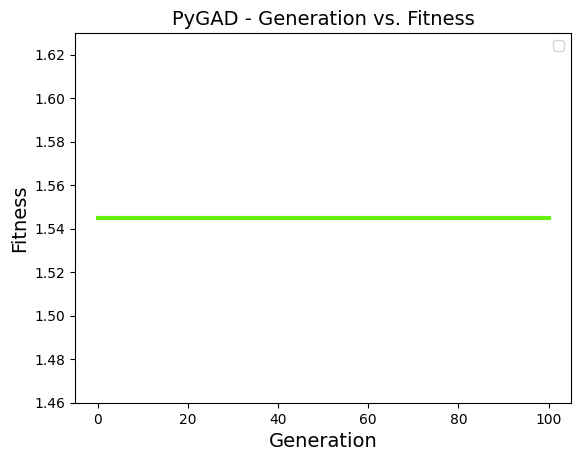

In [ ]:
algo.plot_results()

In [ ]:
a = generate_feasible_individual(num_faculties=4, num_days=61, num_doctor1=19, num_doctor2=17, num_nurse=44, num_doctor1_per_day=1, num_doctor2_per_day=1, num_nurse_per_day=2)


In [54]:
a = np.array([[0, 0, 1, 0, 1, 1, ],
              [0, 1, 1, 1, 0, 1, ],
              [0, 1, 0, 0, 0, 1, ],])
a.swapaxes(1, 0).flatten()

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1])

In [57]:
def get_number_of_consecutive_sequences_longer_than_k(arr, k):
    """
    Calculate the number of consecutive sequences longer than length k in axis 1
    Args:
        arr: binary 2D ndarray
        k: int
    Returns:
        int
    """
    zeros = np.zeros((1, arr.shape[1]))
    arr = np.concatenate([zeros, arr, zeros], axis=0)
    arr = arr.swapaxes(1, 0).flatten()
    print(arr)
    diff = np.diff(arr)
    print(diff)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    
    lengths = ends - starts
    return np.sum(lengths > 1)

In [58]:
get_number_of_consecutive_sequences_longer_than_k(a, 2)

[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 0.]
[ 0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  1.  0. -1.  0.  0.  0.  1. -1.
  0.  0.  1. -1.  0.  0.  0.  1.  0.  0. -1.]


3